In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'

from fastai import *
from fastai.vision import *
from fastai.vision.gan import *
from superRes.generators import *
from superRes.critics import *
from superRes.dataset import *
from superRes.loss import *
from superRes.save import *
from superRes.fid_loss import *
from superRes.ssim import *
from superRes.metrics import *

import torchvision
import geffnet # efficient/ mobile net

In [2]:
path = Path('./dataset/')

path_fullRes = path/'DIV2K_train_HR'

path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'

proj_id = 'unet_superRes_mobilenetV3_LPIPS'

gen_name = proj_id + '_gen'
crit_name = proj_id + '_crit'

name_gen = "unet_superRes_mobilenetV3_LPIPS_image_gen"
path_gen = path/name_gen

generate_training_img = False

In [3]:
crit_name

'unet_superRes_mobilenetV3_LPIPS_crit'

In [4]:
path/name_gen

PosixPath('dataset/unet_superRes_mobilenetV3_LPIPS_image_gen')

In [5]:
def get_crit_data(classes, bs, sz):
    src = ImageList.from_folder(path, include=classes, recurse=True).split_by_rand_pct(0.1)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=sz).databunch(bs=bs, num_workers=4).normalize(imagenet_stats))
    return data

In [6]:
bs = 16
sz = 192

In [7]:
data_crit = get_crit_data([name_gen, "DIV2K_train_HR"], bs=bs, sz=sz)

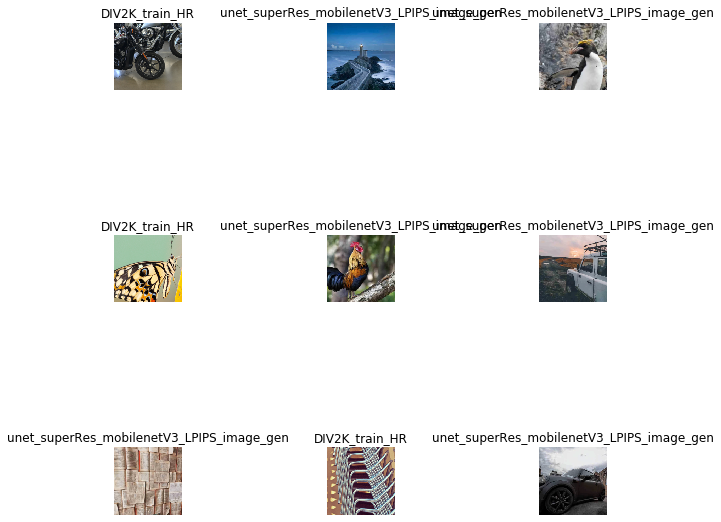

In [8]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [9]:
learn_critic = colorize_crit_learner(data=data_crit, nf=64)

In [10]:
# learn_critic.lr_find()
# learn_critic.recorder.plot()

In [10]:
learn_critic.fit_one_cycle(5, 1e-4)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.694365,0.693106,0.492387,01:57
1,0.693515,0.693131,0.511111,01:56
2,0.693478,0.693152,0.495199,01:55
3,0.693197,0.693148,0.495679,01:58
4,0.693144,0.693139,0.494650,01:59


In [11]:
learn_critic.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.693137,0.693136,0.493690,01:54
1,0.693135,0.693108,0.511454,01:56
2,0.693132,0.693086,0.518313,01:56
3,0.693088,0.693059,0.512071,01:59
4,0.693079,0.693036,0.525514,01:57


In [20]:
learn_critic.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.689947,0.690135,0.518930,01:54
1,0.691158,0.690614,0.500686,01:55
2,0.689052,0.690613,0.501989,01:54
3,0.688726,0.690649,0.501166,01:55
4,0.688299,0.690692,0.501029,01:58


In [19]:
learn_critic.fit_one_cycle(5, 1e-6)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.689039,0.689716,0.531756,01:55
1,0.689977,0.689763,0.524828,01:52
2,0.691695,0.689816,0.524829,01:54
3,0.689943,0.689828,0.524348,01:56
4,0.689910,0.689826,0.524074,01:57


In [15]:
learn_critic.save("/data/students_home/fmameli/repos/SuperRes/models/" + crit_name + "_0")

# GAN

In [7]:
learn_crit=None
learn_gen=None
gc.collect()

0

In [8]:
lr=2e-5
sz=512
bs=1

In [9]:
data_crit = get_crit_data([name_gen, 'test'], bs=bs, sz=sz)

learn_crit = colorize_crit_learner(data=data_crit, nf=64)

weights = "/data/students_home/fmameli/repos/SuperRes/models/unet_superRes_mobilenetV3_LPIPS_Tuned_crit_0"
learn_crit.load(weights, with_opt=False)

Learner(data=ImageDataBunch;

Train: LabelList (810 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
unet_superRes_mobilenetV3_LPIPS_image_gen,unet_superRes_mobilenetV3_LPIPS_image_gen,unet_superRes_mobilenetV3_LPIPS_image_gen,unet_superRes_mobilenetV3_LPIPS_image_gen,unet_superRes_mobilenetV3_LPIPS_image_gen
Path: dataset;

Valid: LabelList (90 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: CategoryList
unet_superRes_mobilenetV3_LPIPS_image_gen,unet_superRes_mobilenetV3_LPIPS_image_gen,unet_superRes_mobilenetV3_LPIPS_image_gen,unet_superRes_mobilenetV3_LPIPS_image_gen,unet_superRes_mobilenetV3_LPIPS_image_gen
Path: dataset;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (1): Dropout2d(p=0.07

In [10]:
model = geffnet.mobilenetv3_rw
loss_func = lpips_loss()

bs=1
sz=512

data_gen = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)

learn_gen = gen_learner_wide(data=data_gen,
                             gen_loss=loss_func,
                             arch = model,
                             nf_factor=2)

weights = "/data/students_home/fmameli/repos/SuperRes/models/unet_wideNf2_superRes_mobilenetV3_P64px_VGG_gen_2"
learn_gen.load(weights, with_opt=False)

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/vgg.pth
...[net-lin [vgg]] initialized
...Done


Learner(data=ImageDataBunch;

Train: LabelList (800 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Valid: LabelList (100 items)
x: ImageImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/DIV2K_train_LR_512_QF20;

Test: None, model=DynamicUnetWide(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): HardSwish()
      (3): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
 

In [11]:
checkpoint_num = 0

In [12]:
gen_new_checkpoint_name = gen_name + "_GAN_" + str(checkpoint_num)

In [13]:
gen_new_checkpoint_name

'unet_superRes_mobilenetV3_LPIPS_gen_GAN_0'

In [14]:
# switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.52)
switcher = partial(FixedGANSwitcher, n_crit=5, n_gen=2)
learn_gan = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.0,1.5), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3)
learn_gan.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn_gan.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_iters=100))

In [ ]:
learn_gan.data = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=1, sz=sz)
learn_gen.freeze_to(-1)
learn_gan.fit(3,lr)

epoch,train_loss,valid_loss,gen_loss,disc_loss,time


In [ ]:
learn_gan.data = get_DIV2k_data_QF(path_lowRes_512, path_fullRes, bs=bs, sz=sz)
learn_gen.unfreeze()
learn_gan.fit(1, 1e-5)

# Validation

In [16]:
learn_gen.metrics.append(SSIM_Metric_gen())
learn_gen.metrics.append(SSIM_Metric_input())
learn_gen.metrics.append(LPIPS_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_gen())
learn_gen.metrics.append(BRISQUE_Metric_input())
learn_gen.metrics.append(BRISQUE_Metric_target())
learn_gen.metrics.append(NIQE_Metric_gen())
learn_gen.metrics.append(NIQE_Metric_input())
learn_gen.metrics.append(NIQE_Metric_target())

Setting up Perceptual loss...
Loading model from: /data/students_home/fmameli/anaconda3/envs/fastai/lib/python3.6/site-packages/perceptual_similarity/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [21]:
val = learn_gen.validate()

In [22]:
print("Gen loss " + str(val[0]))

Gen loss 0.47098973


In [24]:
for name, m in zip(learn_gen.metrics, val[1:]):
    if isinstance(m, torch.Tensor):
        print(name, m.item())
    else:
        print(name, m)

SSIM_Metric_gen 0.6385505199432373
SSIM_Metric_input 0.7075174450874329
LPIPS_Metric_gen 0.21634532511234283
BRISQUE_Metric_gen 85.48798628980043
BRISQUE_Metric_input 87.3549426119021
BRISQUE_Metric_target 85.32215693738695
NIQE_Metric_gen 15.735134
NIQE_Metric_input 17.860744
NIQE_Metric_target 15.693551


In [16]:
learn_gen.metrics

[]

In [21]:
gc.collect()

540

In [47]:
save_name = "unet_wideNf2_superRes_mobilenetV3_GAN_LPIPS_w1.3"
learn_gen.save("/data/students_home/fmameli/repos/SuperRes/models/" + save_name)

# Test gen

In [31]:
bs=1
sz=512

path_lowRes_512 = path/'DIV2K_train_LR_512_QF20'
size=( 512, 680)

In [32]:
data_1k = (ImageImageList.from_folder(path_lowRes_512, presort=True).split_by_idxs(
            train_idx=list(range(0, 800)), valid_idx=list(range(800, 900)))
          .label_from_func(lambda x: path_fullRes/x.name.replace(".jpg", ".png"))
          .transform(get_transforms(), size=size, tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))

In [33]:
learn_gen.data = data_1k
learn_gen.freeze()
gc.collect()

6084

In [34]:
img_index = 2

torch.Size([3, 512, 925])


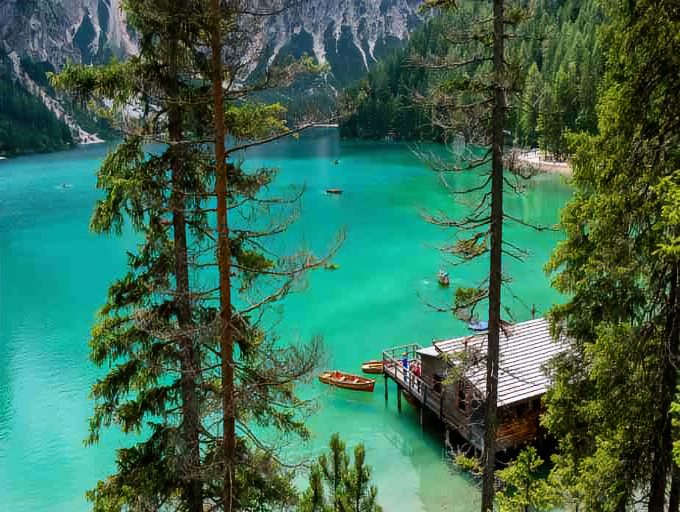

In [39]:
fn = data_1k.valid_dl.x.items[img_index]; fn

img = open_image(fn); print(img.shape)
p,img_hr,b = learn_gen.predict(img)

img_index += 1
p

In [ ]:
img